# Mapping waterbodies according to flow
This notebook merges stream gauge data with satellite data. The user can select a part of the flow duration curve for a chosen gauge then display where the water goes at that flow range. This version was written for hydrologists. The publically available fully marked down version is in the Case_Studies file in your home directory of the sandbox. 

To run a box, click on it and press 'Shift' + 'Enter'. If you ever want to clear it again, click on the Kernel tab in the top left and select Restart Kernal and Clear All Outputs... 

### Load packages
Load key Python packages and supporting functions for the analysis. This notebook relies on a module called `dea_bom`, which is located in the `Scripts` directory. This box retrieves data from the Bureau of Meteorology (BOM) [Water Data Online](http://www.bom.gov.au/waterdata/) webpage using the `dea_bom` module.
We restrict the list of gauges to locations that we have identified as having valid data. Please note that the data in this example is cached. If you wish to access the live BOM website, you will need to go into the Scripts folder and move the file called stations.pkl (which is the cache) out of there so the code can't find it, then it will go to the website instead of using that cahce. 

In [1]:
%matplotlib inline

import os
import sys
import pickle
import datacube
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display
from datacube.storage import masking
from datacube.utils import geometry 
from datacube.utils.geometry import CRS
from datacube.helpers import write_geotiff

sys.path.append('Scripts')
import dea_bom

dc = datacube.Datacube(app='Inundation_mapping')

stations_pkl = Path('Scripts/stations.pkl')

# If cache exists, get station data from cache
if stations_pkl.exists():
    print('Loading from cache')
    stations = pickle.load(open(str(stations_pkl), 'rb'))
else:
    print('Fetching from BoM')
    stations = dea_bom.get_stations()
    pickle.dump(stations, open(str(stations_pkl), 'wb'))

# Filter list to stations with available data
stations_with_data = pickle.load(open(str('Scripts/stations_with_data.pkl'), 'rb'))
stations = [i for i in stations if i.name in stations_with_data]

# Preview the first five stations loaded
print(f'{len(stations)} stations loaded; e.g.:')
stations[:5]

Loading from cache
4305 stations loaded; e.g.:


[namespace(name='15 MILE @ GRETA STH', pos=(-36.61945775, 146.24407214), url='http://bom.gov.au/waterdata/services/stations/403213'),
 namespace(name='15 MILE @ WANGARATTA', pos=(-36.36666667, 146.2833333), url='http://bom.gov.au/waterdata/services/stations/403239'),
 namespace(name='16 Mile Waterhole', pos=(-18.876921, 139.360487), url='http://bom.gov.au/waterdata/services/stations/913010A'),
 namespace(name='163 Clifton Rd', pos=(-32.97808, 115.90111), url='http://bom.gov.au/waterdata/services/stations/6131318'),
 namespace(name='18 Mile Swamp HorseX', pos=(-27.49561971, 153.50836409), url='http://bom.gov.au/waterdata/services/stations/144005A')]

## Plot a map of stations and select a gauge that contains data

Running this cell will generate a map displaying the locations of stream gauges in Australia. It will take about 20 seconds to load. Choose a gauge on the map by clicking on it. Note that after you click on a gauge it can take a second or two to respond. 

When you have the station you want, **click the Done button before moving onto the next box**. If you don't click Done then the rest of the code won't run. If you want to choose a different gauge after having pressed the `Done` button, you must re-run this box to regenerate the map then choose another gauge and press `Done` again. 

> **Note:** If all gauges you click on return "0 observations", this could indicate an issue with fetching data from the BOM webpage. In this case, re-start the notebook and try again later

In [31]:
gauge_data, station = dea_bom.ui_select_station(stations)

## Generate a flow duration curve from the data selected above
This box will generate a Flow Duration Curve from the gauge data. You can then choose which flow rate values to analyse. 

The code in the box below will automatically select the latitude and longitude of the selected gauge, but you can enter a different `lat` and `lon` if you want by editing the commented out `lat` and `lon` lines in the code below. 
The output will tell you what `lat` and `lon` has been selected. 
The `buffer`, which is the radius around the location point, is set to 8000 meters but you can change it if you like.

> **Note:** If nothing happens when you run this cell, **return to the previous cell and click the Done button**

You have selected: lat = -29.9164
You have selected: lon = 151.1148


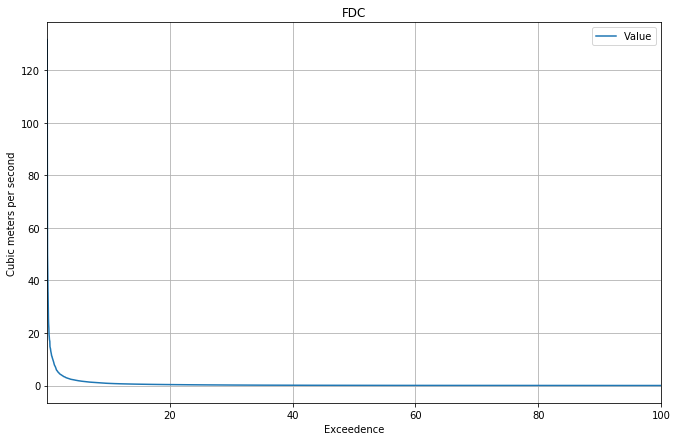

In [24]:
# The lat and lon takes the location of the gauge. You can change the lat 
# and lon to a different location if necessary, just comment out out this 
# lat, lon = pos line below and define your own.
lat, lon = station.pos

# lat =
# lon =

# The buffer is how many meters radius around the location you want to display.
buffer = 8000

# Rearranging data into a flow duration curve
gauge_data = gauge_data.dropna()
gauge_data = gauge_data.sort_values('Value')
gauge_data['rownumber'] = np.arange(len(gauge_data))
gauge_data['Exceedence'] = (1 - (gauge_data.rownumber / len(gauge_data))) * 100

# Plotting the flow duration curve
gauge_data.plot(x='Exceedence', y='Value', figsize=(11, 7))
plt.ylabel('Cubic meters per second')
plt.grid(True)
plt.title('FDC')

print(f'You have selected: lat = {lat}')
print(f'You have selected: lon = {lon}')


## Enter the y-axis parameters in cubic meters per second
Please change the y-axis parameters in the box below based on the FDC.

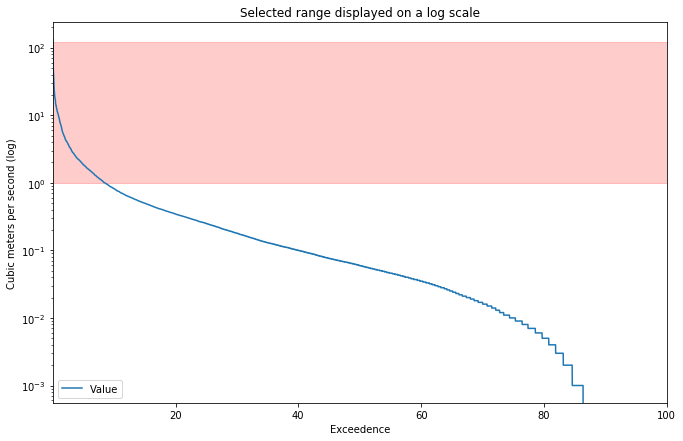

In [27]:
# What part of the Flow Duration Curve do you want to look at?
yaxis_lower_parameter = 1
yaxis_higher_parameter = 120




# Plot the data on a log scale
gauge_data.plot(x='Exceedence',
                y='Value',
                logy=True,
                title='Selected range displayed on a log scale',
                figsize=(11, 7))
plt.axhspan(yaxis_lower_parameter,
            yaxis_higher_parameter,
            color='red',
            alpha=0.2)
plt.ylabel('Cubic meters per second (log)');


## Merge the gauge data with the satellite data
The output of this box will tell you how many satellite passes you are about to load. If you want more passes, you will have to broaden the FDC parameters.

In [28]:
# Set up a query which defines the area and time period to load data for
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer, x + buffer),
         'y': (y - buffer, y + buffer),    
         'time': ('2016-01-01', '2019-10-01'), # Change this date accordingly
         'crs': 'EPSG:3577'} 

# Dask load wofs_albers data (this loads the dataset parameters only, 
# not the actual satellite data)
wofs_albers = dc.load(product = 'wofs_albers', 
                      dask_chunks = {}, 
                      group_by='solar_day', 
                      **query)

# Merging satellite data with gauge data by timestamp
gauge_data_xr = gauge_data.to_xarray()
merged_data = gauge_data_xr.interp(Timestamp=wofs_albers.time, method='nearest')

# Here is where it takes into account user input for the FDC
specified_level = merged_data.where((merged_data.Value > yaxis_lower_parameter) & 
                                    (merged_data.Value < yaxis_higher_parameter), 
                                    drop=True)

# Get list of dates to keep
date_list = specified_level.time.values

print(f'You are about to load {specified_level.time.shape[0]} satellite passes')

You are about to load 5 satellite passes


## Generate the image
This box includes a cloudmasking step. The output will tell you how many passes you got after cloudmasking. It will also generate a frequency image of what the water body looked like while the gauge was reading the specified flows.

After cloud filtering, there are 2 passes available, which were used to make this image



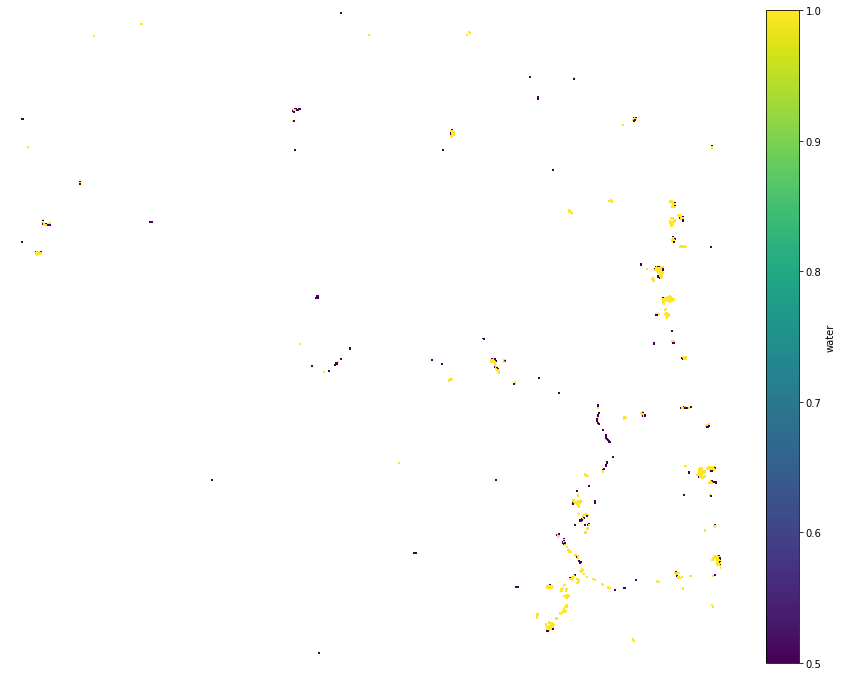

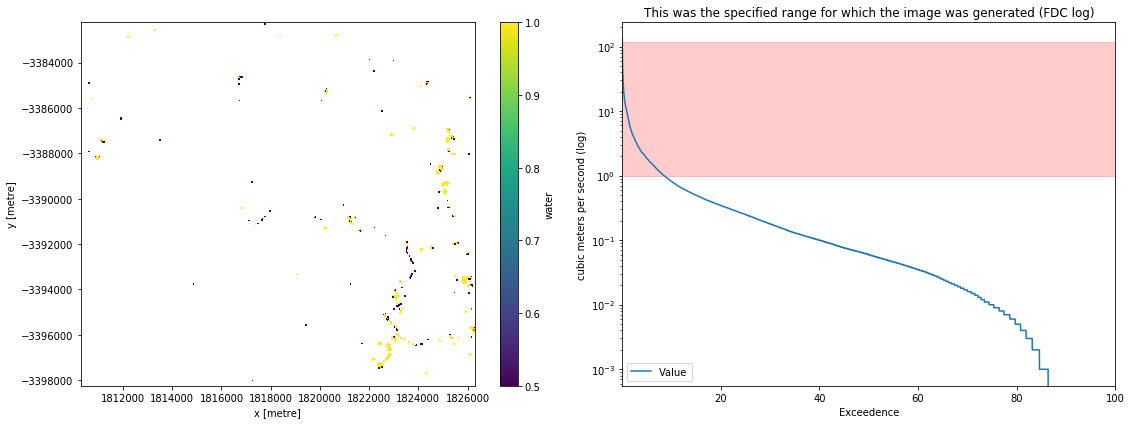

In [29]:
# Load the passes that happened during the specified flow parameters
specified_passes = wofs_albers.sel(time=date_list).compute()

# Calculate the number of cloudy pixels per timestep
cc = masking.make_mask(specified_passes.water, cloud=True)
ncloud_pixels = cc.sum(dim=['x', 'y'])

# Calculate the total number of pixels per timestep
npixels_per_slice = (specified_passes.water.shape[1] * 
                     specified_passes.water.shape[2])

# Calculate the proportion of cloudy pixels
cloud_pixels_fraction = (ncloud_pixels / npixels_per_slice)

# Filter out "too cloudy" passes (i.e. more than 50% cloud)
clear_specified_passes = specified_passes.water.isel(
    time=cloud_pixels_fraction < 0.5)

print(f'After cloud filtering, there are '
      f'{clear_specified_passes.time.shape[0]} passes available, which were used to make this image\n')



# Identify all wet and dry pixels
wet = masking.make_mask(clear_specified_passes, wet=True).sum(dim='time')
dry = masking.make_mask(clear_specified_passes, dry=True).sum(dim='time')

# Calculate how frequently each pixel was wet when it was observed
clear = wet + dry
frequency = wet / clear

# Remove persistent NAs that occur due to mountain shadows
frequency = frequency.fillna(0)  

# Set pixels that remain dry 100% of the time to nodata so they appear white
frequency = frequency.where(frequency != 0)  

#Plotting the image
frequency.plot(figsize = (16, 12))
plt.axis('off')

fig, ax = plt.subplots(ncols=2, figsize=(16, 6))

ax1 = frequency.plot(ax=ax[0])

ax2 = gauge_data.plot(x='Exceedence', y='Value', ax=ax[1]) 
ax2 = plt.axhspan(yaxis_lower_parameter, yaxis_higher_parameter, color='red', alpha=0.2)
ax2 = plt.title('This was the specified range for which the image was generated (FDC log)')
ax2 = plt.ylabel('cubic meters per second (log)')
ax2 = plt.xlabel('Exceedence')
ax2 = plt.yscale('log')

plt.tight_layout()

## Save the file as a GeoTIFF
You might want to use this water frequency image in another workflow.
The following code will export the image as a `.tif` GeoTIFF file that can be loaded into common GIS software (e.g. ArcMap or QGIS). 

Enter a name for the `.tif` file below. 
The `../` part of the name means it will save this file one directory up from where this notebook is saved.

In [ ]:
# Set the output file name 
file_name = '../file_name_here.tif'

# Set up the file for writing
frequency_dataset = frequency.to_dataset()
frequency_dataset.attrs=wofs_albers.attrs

# Write GeoTIFF to a location
write_geotiff(file_name, frequency_dataset)